# Imports

In [1]:
# all imports

import pandas as pd
from itertools import combinations

# for networkx

import networkx as nx
import matplotlib.pyplot as plt
import community 
import pandas as pd
import numpy as np

# Creating All Dataframes (5 Minutes to Run)

In [2]:
df_titles = pd.read_csv('title.basics.tsv', sep='\t')

/var/folders/sy/d69xwzdn6q73cqq4lfn917km0000gn/T/ipykernel_74128/2949989337.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_titles = pd.read_csv('title.basics.tsv', sep='\t')


In [3]:
df_principals = pd.read_csv('title.principals.tsv', sep='\t')

In [4]:
df_actors = pd.read_csv('name.basics.tsv', sep='\t')

# Creating Node and Edge CSV Files for the Network

## Cleaning Dataframes

In [5]:
# cleaning df_titles

df_titles_clean = df_titles.copy()

# remove everything but movies
df_titles_clean_0 = df_titles_clean[df_titles_clean['titleType'] == 'movie']

# remove adult titles
df_titles_clean_1 = df_titles_clean_0[df_titles_clean_0['isAdult'] != 1]

# remove start year being '\N'
df_titles_clean_2 = df_titles_clean_1[df_titles_clean_1['startYear'] != '\\N']

# remove movies older than 1925 (assuming no actor is older than 100)
df_titles_clean_2['startYear'] = pd.to_numeric(df_titles_clean_2['startYear'], errors='coerce')
df_titles_clean_3 = df_titles_clean_2[df_titles_clean_2['startYear'] >= 1925]

# remove movies not released yet (past 2024)
df_titles_clean_4 = df_titles_clean_3[df_titles_clean_3['startYear'] <= 2024]

df_titles_final = df_titles_clean_4.copy()

/var/folders/sy/d69xwzdn6q73cqq4lfn917km0000gn/T/ipykernel_74128/2688604394.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_titles_clean_2['startYear'] = pd.to_numeric(df_titles_clean_2['startYear'], errors='coerce')


## Manipulating Dataframes for MCU Movies - Creating MCU Movies CSV File

### Filtering to Just MCU Movies

In [6]:
'''filtering to just mcu movies'''

# remove movies older than 2008 (as that was the first mcu release movie)
df_titles_final = df_titles_final[df_titles_final['startYear'] >= 2008]

# load the CSV file containing the filter values
mcu_movies_list = pd.read_csv('mcu_movies_list.csv')

# Filter the df_titles DataFrame based on the values from the CSV file
df_mcu_movies = df_titles_final[df_titles_final['primaryTitle'].isin(mcu_movies_list['Movie Title'])]

# Remove duplicates based on the originalTitle column
df_mcu_movies = df_mcu_movies[df_mcu_movies['primaryTitle'] == df_mcu_movies['originalTitle']]

# remove black widow movie duplicates
df_mcu_movies = df_mcu_movies[~((df_mcu_movies['primaryTitle'] == 'Black Widow') & (df_mcu_movies['startYear'] != 2021))]

In [7]:
# get id of each movie into csv file
# tconst_series = df_mcu_movies['tconst']
# tconst_series.to_csv('id_mcu_movies.csv', index=False)

mcu_movies_ids_titles = df_mcu_movies[['tconst', 'primaryTitle']]
mcu_movies_ids_titles.columns = ['tconst', 'title']
folder_path = 'logistics/'
mcu_movies_ids_titles.to_csv(f'{folder_path}id_mcu_movies.csv', index=False)

OSError: Cannot save file into a non-existent directory: 'logistics'

### Filtering to Just MCU Actors

In [8]:
# filtering df_principals to get actors and actresses 

'''
# Unique values of category 
unique_values = df_principals['category'].unique()
print(unique_values)
# ['self' 'director' 'producer' 'cinematographer' 'composer' 'editor'
# 'actor' 'actress' 'writer' 'production_designer' 'archive_footage'
# 'casting_director' 'archive_sound']
'''

df_principals_clean = df_principals[df_principals['category'].isin(['actor', 'actress'])]

# filter dataframe using title from id_mcu_movies csv file
id_mcu_movies = pd.read_csv('logistics/id_mcu_movies.csv')
df_principals_mcu_actors = df_principals_clean[df_principals_clean['tconst'].isin(id_mcu_movies['tconst'])]
df_principals_mcu_actors = df_principals_mcu_actors.drop_duplicates()
# print(df_principals_mcu_actors.head())

In [9]:
# create csv file of all actor ids of cast of the mcu movies
mcu_actors_ids = df_principals_mcu_actors['nconst']
folder_path = 'logistics/'
mcu_actors_ids.to_csv(f'{folder_path}id_mcu_actors.csv', index=False)

In [10]:
# create csv file of actors, movies and titles
df_mcu_movie_actor_merge = df_principals_mcu_actors.merge(df_mcu_movies[['tconst', 'primaryTitle']], on='tconst', how='left')
df_mcu_ids = df_mcu_movie_actor_merge[['nconst', 'tconst', 'primaryTitle']]
df_mcu_ids = df_mcu_ids.rename(columns={'primaryTitle': 'title'})
folder_path = 'logistics/'
df_mcu_ids.to_csv(f'{folder_path}mcu_movies.csv', index=False)

### Get MCU Actor Names into the CSV file

In [11]:
# filtering df_actors to get only the mcu actors in the data frame

mcu_actors_ids = df_principals_mcu_actors['nconst']
df_actors_mcu = df_actors[df_actors['nconst'].isin(mcu_actors_ids)]
df_actors_mcu = df_actors_mcu.drop_duplicates()

In [12]:
# adding the actors names into the id_mcu_actors csv file

id_mcu_actors = pd.read_csv('logistics/id_mcu_actors.csv')
df_actors_mcu_with_names = id_mcu_actors.merge(df_actors_mcu[['nconst', 'primaryName']], on='nconst', how='left')
df_actors_mcu_with_names = df_actors_mcu_with_names.rename(columns={'primaryName' : 'name'})
df_actors_mcu_with_names.to_csv('logistics/id_mcu_actors.csv', index=False)

In [13]:
# adding the actors names to the mcu_movies csv file

df_mcu_network = pd.read_csv('logistics/mcu_movies.csv')
df_mcu_network_with_names = df_mcu_network.merge(df_actors_mcu[['nconst', 'primaryName']], on='nconst', how='left')
df_mcu_network_with_names = df_mcu_network_with_names.rename(columns={'primaryName' : 'name'})
df_mcu_network_with_names = df_mcu_network_with_names.drop_duplicates()
df_mcu_network_with_names.to_csv('logistics/mcu_movies.csv', index=False)

## Manipulating Dataframes for Non-MCU Movies - Creating Non - MCU Movies CSV File

In [14]:
# getting all movies done by mcu actors 

df_mcu_actors = pd.read_csv('logistics/id_mcu_actors.csv')
df_nonmcu_movies_noname = df_principals_clean[df_principals_clean['nconst'].isin(id_mcu_actors['nconst'])]

# cleaning up dataframe
columns_to_drop = ['ordering', 'job']
df_nonmcu_movies_noname = df_nonmcu_movies_noname.drop(columns=columns_to_drop)

In [ ]:
num_rows = df_nonmcu_movies_noname.shape[0]
print("number of rows: ",  num_rows)

# print(df_nonmcu_movies_noname)

number of rows:  29089


In [16]:
# add actor names to dataframe
df_nonmcu_movies = df_nonmcu_movies_noname.merge(df_mcu_actors[['nconst', 'name']], on='nconst', how='left')

In [17]:
# add movie title to dataframe

df_nonmcu_movies_with_titles = df_nonmcu_movies.merge(df_titles_final[['tconst', 'primaryTitle']], on='tconst', how='left')

In [18]:
# Drop rows where primaryTitle is NaN
df_nonmcu_movies_with_titles_cleaned = df_nonmcu_movies_with_titles.dropna(subset=['primaryTitle'])
df_nonmcu_movies_with_titles_cleaned = df_nonmcu_movies_with_titles_cleaned.drop_duplicates()

In [19]:
# remove mcu movies from this dataframe
mcu_movies = pd.read_csv('mcu_movies_list.csv')
df_nonmcu_movies_filtered = df_nonmcu_movies_with_titles_cleaned[~df_nonmcu_movies_with_titles_cleaned['primaryTitle'].isin(mcu_movies['Movie Title'])]

In [20]:
# save to csv 
df_nonmcu_movies_filtered.to_csv('logistics/nonmcu_movies.csv', index=False)

## Combining MCU and Non-MCU Movies Into Single File

In [21]:
# LOADING THE MCU AND NON-MCU MOVIE CSV FILES INTO VARIABLES 

original_mcu_movies = pd.read_csv('logistics/mcu_movies.csv')
original_nonmcu_movies = pd.read_csv('logistics/nonmcu_movies.csv')

In [22]:
# CREATING EDGES FILE - DOING PREP
# create a dataframe that has edges defining costarring relationships 
# adding edges for mcu network
mcu_movies_copy1 = original_mcu_movies.copy()

links = []
grouped = mcu_movies_copy1.groupby('tconst')

for tconst, group in grouped:
    actor_pairs = combinations(group['nconst'], 2)
    for source, target in actor_pairs:
        source_name = group[group['nconst'] == source]['name'].values[0]
        target_name = group[group['nconst'] == target]['name'].values[0]
        title = group['title'].values[0]
        links.append({'source': source, 'source_name': source_name, 'target': target, 'target_name': target_name, 'title': title, 'weight': 1})

df_mcu_costarring_network = pd.DataFrame(links)
df_mcu_costarring_network.to_csv('mcu_costarring_network.csv', index=False)

In [23]:
# adding edges for nonmcu network
nonmcu_movies_copy0 = original_nonmcu_movies.copy()

links = []
grouped = nonmcu_movies_copy0.groupby('tconst')

for tconst, group in grouped:
    actor_pairs = combinations(group['nconst'], 2)
    for source, target in actor_pairs:
        source_name = group[group['nconst'] == source]['name'].values[0]
        target_name = group[group['nconst'] == target]['name'].values[0]
        title = group['primaryTitle'].values[0]
        links.append({'source': source, 'source_name': source_name, 'target': target, 'target_name': target_name, 'title': title, 'weight': -1})

df_nonmcu_costarring_network = pd.DataFrame(links)

# remove any rows where the source and target are the same 
df_nonmcu_costarring_network = df_nonmcu_costarring_network[df_nonmcu_costarring_network['source'] != df_nonmcu_costarring_network['target']]

df_nonmcu_costarring_network.to_csv('nonmcu_costarring_network.csv', index=False)

In [24]:
# merge the dataframe and save to csv

df_combined_costarring_network = pd.concat([df_nonmcu_costarring_network, df_mcu_costarring_network])
df_combined_costarring_network = df_combined_costarring_network.reset_index(drop=True)

# print(df_combined_costarring_network)
df_combined_costarring_network.to_csv('combined_costarring_network.csv', index=False)

In [25]:
# Update dataframe with edges where there are both marvel and non marvel movies 

df_combined_costarring_network_copy = df_combined_costarring_network.copy()

pairs_to_update = set()

for index, row in df_combined_costarring_network_copy.iterrows():
    source = row['source']
    target = row['target']
    weight = row['weight']
    
    opposite_weight = -weight
    if ((df_combined_costarring_network_copy['source'] == source) & 
        (df_combined_costarring_network_copy['target'] == target) & 
        (df_combined_costarring_network_copy['weight'] == opposite_weight)).any():
        pairs_to_update.add((source, target))

for source, target in pairs_to_update:
    # Get the names and title for the source and target
    source_name = df_combined_costarring_network_copy[
        (df_combined_costarring_network_copy['source'] == source) & 
        (df_combined_costarring_network_copy['target'] == target)]['source_name'].values[0]
    target_name = df_combined_costarring_network_copy[
        (df_combined_costarring_network_copy['source'] == source) & 
        (df_combined_costarring_network_copy['target'] == target)]['target_name'].values[0]
    title = df_combined_costarring_network_copy[
        (df_combined_costarring_network_copy['source'] == source) & 
        (df_combined_costarring_network_copy['target'] == target) & 
        (df_combined_costarring_network_copy['weight'] == -1)]['title'].values[0]
    
    df_combined_costarring_network_copy = df_combined_costarring_network_copy[
        ~((df_combined_costarring_network_copy['source'] == source) & 
          (df_combined_costarring_network_copy['target'] == target))]
    
    new_row = pd.Series({
    'source': source, 
    'source_name': source_name, 
    'target': target, 
    'target_name': target_name, 
    'title': title, 
    'weight': 0
    })
    df_combined_costarring_network_copy = pd.concat([df_combined_costarring_network_copy, new_row.to_frame().T], ignore_index=True)
    # df_combined_costarring_network_copy = df_combined_costarring_network_copy.append(
    #     {'source': source, 'source_name': source_name, 'target': target, 'target_name': target_name, 'title': title, 'weight': 0}, 
    #     ignore_index=True)

df_combined_costarring_network_copy.to_csv('networks/final_combined_costarring_network.csv', index=False)

## Translate CSV Files into formats suitable for Gephi

In [26]:
# CREATING NODE FILE
# create CSV with headers 'nconst' | 'name' | 'category'

mcu_movies_copy0 = original_mcu_movies.copy()

df_gephi_actors = mcu_movies_copy0[['nconst', 'name']]
df_gephi_actors = df_gephi_actors.drop_duplicates()
df_gephi_actors = df_gephi_actors.rename(columns={'name' : 'Label'})
df_gephi_actors = df_gephi_actors.rename(columns={'nconst' : 'id'})
df_gephi_actors.to_csv('networks/costarring_network_nodes.csv', sep=';', index=False)

In [27]:
# separating csv file into semicolons with headers: 'source', 'target', 'weight', 'type'

df_combined_costarring_network_gephi = df_combined_costarring_network_copy.copy()
# df_combined_costarring_network_gephi.loc[df_combined_costarring_network_gephi['weight'] == -1, 'weight'] = 2
# df_combined_costarring_network_gephi.loc[df_combined_costarring_network_gephi['weight'] == 0, 'weight'] = 3
df_combined_costarring_network_gephi = df_combined_costarring_network_gephi.rename(columns={'weight': 'relationship'})
df_combined_costarring_network_gephi['type'] = 'undirected'
df_combined_costarring_network_gephi = df_combined_costarring_network_gephi.drop(columns=['title'])
df_combined_costarring_network_gephi.to_csv('networks/costarring_network_edges.csv', sep=';', index=False)

# NetworkX Statistics

In [31]:
# Create graph from edges file
edges_df = pd.read_csv("networks/costarring_network_edges.csv", delimiter=';')
G = nx.Graph()
for index, row in edges_df.iterrows():
    G.add_edge(row['source'], row['target'], relationship=row['relationship'])

    G.nodes[row['source']]['source_name'] = row['source']
    G.nodes[row['target']]['target_name'] = row['target']

## Calculating Basic Network Properties

Average Degree: 18.08
Highest Degree: 73
Lowest Degree: 9


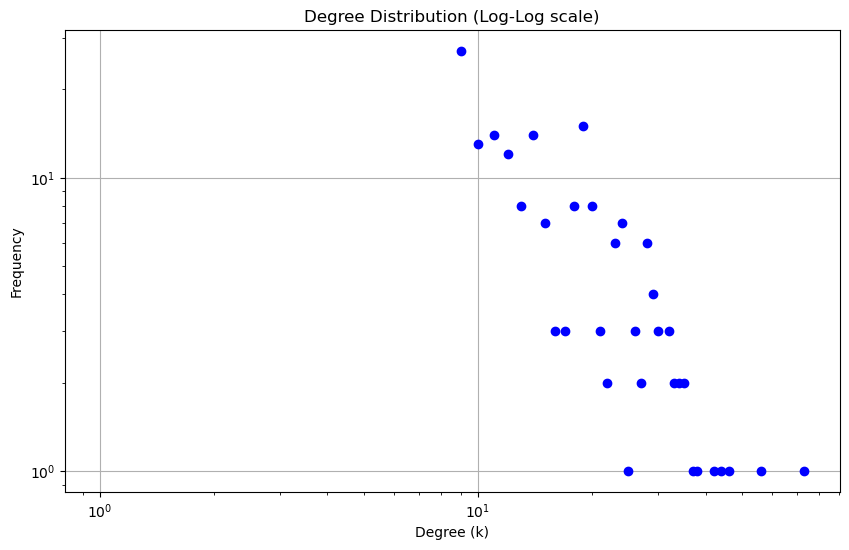

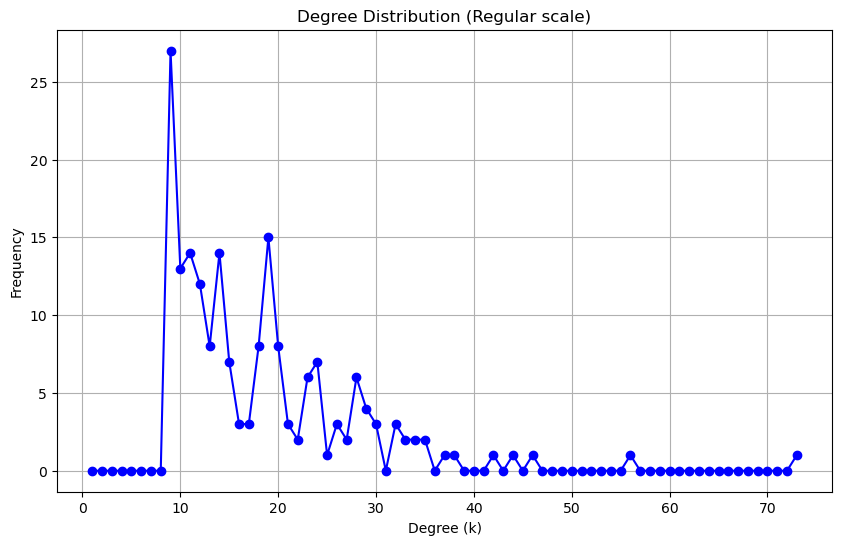

In [ ]:
# DEGREE DISTRIBUTION, AVERAGE DEGREE, MAX AND MIN DEGREES

degree_sequence = [d for n, d in G.degree()]
degree_count = np.bincount(degree_sequence)
degree = np.arange(len(degree_count))

avg_degree = np.mean(degree_sequence)
print(f"Average Degree: {avg_degree:.2f}")

max_degree = np.max(degree_sequence)
print(f"Highest Degree: {max_degree}")

min_degree = np.min(degree_sequence)
print(f"Lowest Degree: {min_degree}")

# Log-Log Scale Plot
plt.figure(figsize=(10, 6))
plt.loglog(degree[degree > 0], degree_count[degree > 0], marker='o', linestyle='None', color='blue')
plt.title('Degree Distribution (Log-Log scale)')
plt.xlabel('Degree (k)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Regular Scale Plot
plt.figure(figsize=(10, 6))
plt.plot(degree[degree > 0], degree_count[degree > 0], marker='o', linestyle='-', color='blue')
plt.title('Degree Distribution (Regular scale)')
plt.xlabel('Degree (k)')
plt.ylabel('Frequency')
plt.grid(True)

In [33]:
# KEY NETWORK PROPERTIES 
# AVERAGE SHORTEST PATH LENGTH
# NETWORK DIAMETER
# CLUSTERING COEFFICIENT
# ASSORTATIVE VALUE


avg_path_length = nx.average_shortest_path_length(G)
diameter = nx.diameter(G)
clustering_coeff = nx.average_clustering(G)
assortativity = nx.degree_assortativity_coefficient(G)

print(f"Average Shortest Path Length: {avg_path_length:.2f}")
print(f"Diameter: {diameter}")
print(f"Clustering Coefficient: {clustering_coeff:.2f}")
print(f"Assortativity Coefficient: {assortativity:.2f}")

Average Shortest Path Length: 2.24
Diameter: 4
Clustering Coefficient: 0.55
Assortativity Coefficient: 0.06


## RQ1

In [34]:
# Create graph from edges file
edges_df = pd.read_csv("networks/costarring_network_edges.csv", delimiter=';')
G = nx.Graph()
for index, row in edges_df.iterrows():
    G.add_edge(row['source'], row['target'], relationship=row['relationship'])

    G.nodes[row['source']]['source_name'] = row['source']
    G.nodes[row['target']]['target_name'] = row['target']

Modularity Score: 0.4660684493830269
Number Of Communities:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}


/var/folders/sy/d69xwzdn6q73cqq4lfn917km0000gn/T/ipykernel_68842/4217563998.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(communities))  # Get a colormap with enough distinct colors
/Users/sachilad/anaconda3/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


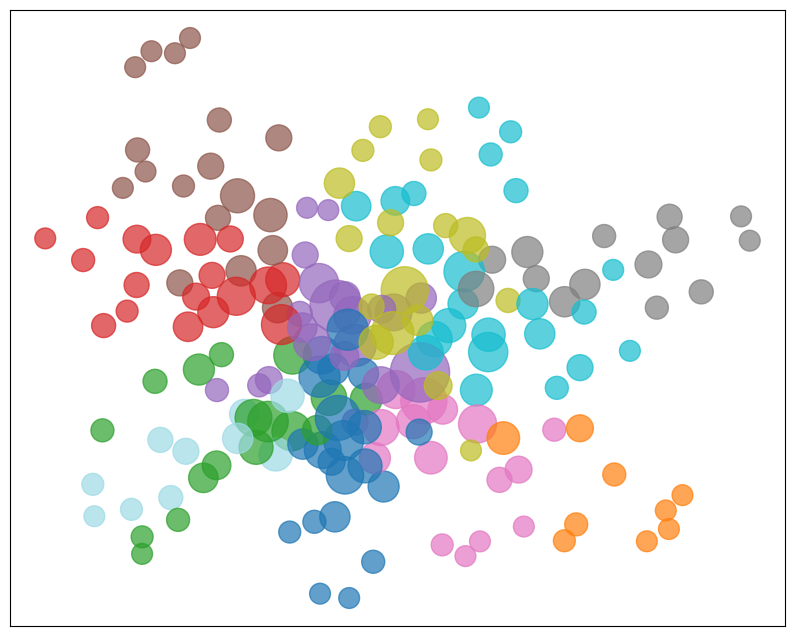

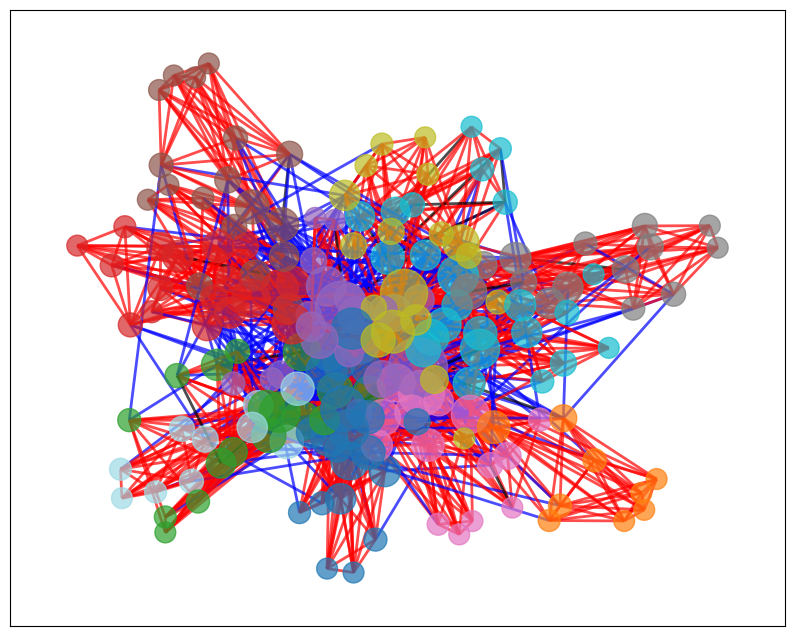

In [35]:
# COMMUNITY DETECTION USING LOUVAIN METHOD

partition = community.best_partition(G)
modularity_score = community.modularity(partition, G)
print(f"Modularity Score: {modularity_score}")
communities = set(partition.values())
print("Number Of Communities: ", communities)

# Visualize the communities
colors = plt.cm.get_cmap('tab20', len(communities))  # Get a colormap with enough distinct colors
community_colors = {comm: colors(i) for i, comm in enumerate(communities)}
node_colors = [community_colors[partition[node]] for node in G.nodes()]

relationship_colors = {
    1: 'red',
    -1: 'blue',
    0: 'black'
}

edge_colors = [relationship_colors[G[u][v]['relationship']] for u, v in G.edges()]
node_degrees = dict(G.degree())
node_sizes = [node_degrees[node] * 25 for node in G.nodes()] # Multiply by a factor for better visibility

# Graph without edges
plt.figure(figsize=(10, 8))
pos = nx.fruchterman_reingold_layout(G, k=0.07, seed=42)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, cmap=plt.cm.jet, alpha=0.7)
plt.show()

# Graph with edges
plt.figure(figsize=(10, 8))
pos = nx.fruchterman_reingold_layout(G, k=0.07, seed = 42)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, cmap=plt.cm.jet, alpha=0.7)
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=2, alpha=0.7)
plt.show()


## RQ2

In [ ]:
# TESTING FOR SMALL WORLD PHENOMENON

# Create graph from edges file
edges_df = pd.read_csv("networks/costarring_network_edges.csv", delimiter=';')
G = nx.Graph()
for index, row in edges_df.iterrows():
    G.add_edge(row['source'], row['target'], relationship=row['relationship'])

    G.nodes[row['source']]['source_name'] = row['source']
    G.nodes[row['target']]['target_name'] = row['target']

# statistics for co-starring
clustering_coefficient = nx.average_clustering(G)
print("Clustering Coefficient:", clustering_coefficient)
avg_path_length = nx.average_shortest_path_length(G)
print("Average Path Length:", avg_path_length)

# statistics for random network 
num_nodes = len(G.nodes())
num_edges = len(G.edges())
p = (2 * num_edges) / (num_nodes * (num_nodes - 1))  
random_graph = nx.erdos_renyi_graph(num_nodes, p)

random_clustering = nx.average_clustering(random_graph)
random_avg_path_length = nx.average_shortest_path_length(random_graph)

print("Random Network Clustering Coefficient:", random_clustering)
print("Random Network Average Path Length:", random_avg_path_length)


Clustering Coefficient: 0.5472205325427928
Average Path Length: 2.242596944770858
Random Network Clustering Coefficient: 0.101383002109976
Random Network Average Path Length: 2.052585193889542


{0: 0.0982373678025852, 1: 0.0982373678025852, 2: 0.0982373678025852, 3: 0.0982373678025852, 4: 0.0982373678025852, 5: 0.0982373678025852, 6: 0.0982373678025852, 7: 0.0982373678025852, 8: 0.0982373678025852, 9: 0.11658469725066516, 10: 0.12796934865900383, 11: 0.14221961244862008, 12: 0.15653040877367896, 13: 0.16642096642096643, 14: 0.18943298969072164, 15: 0.20399500624219724, 16: 0.20930232558139536, 17: 0.21485943775100402, 18: 0.2294736842105263, 19: 0.2650273224043716, 20: 0.2960812772133527, 21: 0.3069387755102041, 22: 0.3182624113475177, 23: 0.3554006968641115, 24: 0.40336134453781514, 25: 0.4117647058823529, 26: 0.4258064516129032, 27: 0.4482758620689655, 28: 0.4743083003952569, 29: 0.5029239766081871, 30: 0.5666666666666667, 31: 0.5666666666666667, 32: 0.6282051282051282, 33: 0.6909090909090909, 34: 0.8888888888888888, 35: 0.9047619047619048, 36: 0.9047619047619048, 37: 0.8666666666666667, 38: 0.9, 39: 0.9, 40: 0.9, 41: 0.9, 42: 0.8333333333333334, 43: 0.8333333333333334, 44:

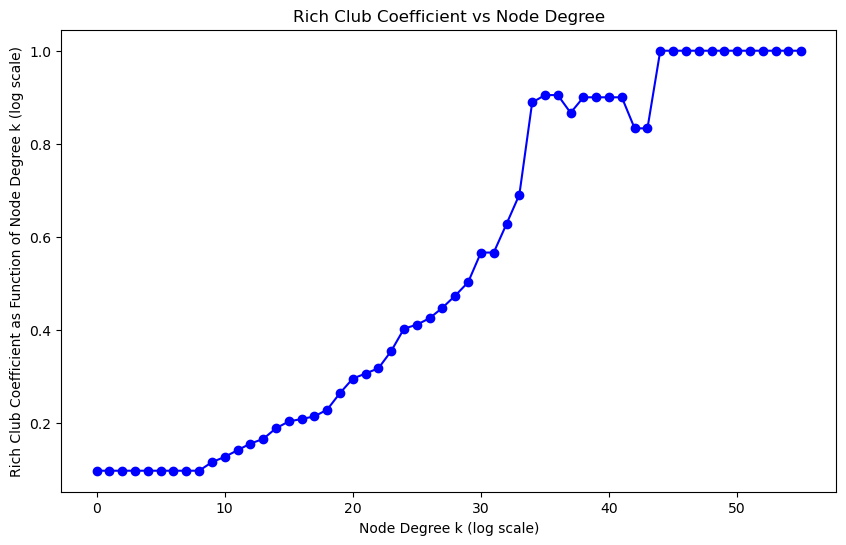

In [37]:
# PLOTTING RICH CLUB COEFFICIENT AS A FUNCTION OF NODE DEGREE K

edges_df = pd.read_csv("networks/costarring_network_edges.csv", delimiter=';')
G = nx.Graph()
for index, row in edges_df.iterrows():
    G.add_edge(row['source'], row['target'], relationship=row['relationship'])

    G.nodes[row['source']]['source_name'] = row['source']
    G.nodes[row['target']]['target_name'] = row['target']

rich_club = nx.rich_club_coefficient(G=G, normalized=False, seed=42)

degrees = list(rich_club.keys())
coefficients = list(rich_club.values())

# Plot the rich club coefficient on a log-log scale
plt.figure(figsize=(10, 6))
plt.plot(degrees, coefficients, marker='o', linestyle='-', color='b')
plt.xlabel('Node Degree k (log scale)')
plt.ylabel('Rich Club Coefficient as Function of Node Degree k (log scale)')
plt.title('Rich Club Coefficient vs Node Degree')
plt.show()